In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataloader import RadarImageTargetSet
from sklearn.model_selection import StratifiedKFold
ds = RadarImageTargetSet()

In [4]:
boxes = []
for (img, tgt) in ds:
    for box in tgt['boxes']:
        boxes.append(box)
boxes = np.array(boxes)
box_xsizes = boxes[:, 2] - boxes[:, 0]
box_ysizes = boxes[:, 3] - boxes[:, 1]
max_x_size = int(max(box_xsizes))
max_y_size = int(max(box_ysizes))

print(max_x_size, max_y_size)

11 27


In [5]:
# prepare training data for DopplerNet like model

# box cutouts
x = []
# box center positions in radar frame
c = []
# classes in one hot encoding
y = []
for (img, tgt) in ds:
    #print(img.shape)
    for (class_type, (y0, x0, y1, x1)) in zip(tgt['labels'], list(tgt['boxes'])):
        c.append([0.5 * (x0 + x1), 0.5 * (y0 + y1)])
        # cut box out of image
        #print(class_type)
        #print(x0, y0, x1, y1)
        cutout = img[int(x0):int(x1), int(y0):int(y1)]
        #print(cutout.shape)
        if cutout.shape[0] > max_x_size and cutout.shape[1] > max_y_size:
            print("can't process box of shape", x0, y0, x1, y1, cutout.shape)
            continue
        # padding putting it in upper left corner
        # TODO: center
        y_padding = int(max_y_size - cutout.shape[0])
        x_padding = int(max_x_size - cutout.shape[1])
        padded = np.pad(cutout, ((y_padding // 2, y_padding - (y_padding // 2)), (x_padding // 2, x_padding - (x_padding // 2))), mode='constant', constant_values=0.0)
        x.append(padded)
        # class as one hot encoding
        y.append([1.0 if int(class_type) == i else 0.0 for i in range(4)])

x = np.array(x)
c = np.array(c)
y = np.array(y)
print(x.shape)
print(c.shape)
print(y.shape)

(594, 27, 11)
(594, 2)
(594, 4)


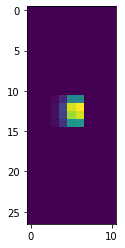

In [6]:
plt.imshow(x[28])

In [7]:
from sklearn.model_selection import train_test_split 
x_train,x_test,c_train,c_test,y_train,y_test=train_test_split(x, c, y, test_size=0.33, random_state=42)

x_train=np.asarray(x_train)
c_train=np.asarray(c_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
c_test=np.asarray(c_test)
y_test=np.asarray(y_test)
x_train=np.reshape(x_train,[-1,11,27,1])
c_train=np.reshape(c_train,[-1,2,1])
x_test=np.reshape(x_test,[-1,11,27,1])

In [54]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.layers import Dense, Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
#from k.layers.Input as Input
#from k.layers.Conv2D as Conv2D

#model=k.Sequential()
#model.add(tf.keras.Input(shape=(11,27,1)))
#model.add(k.layers.Conv2D(32,3,3,padding='valid',
#    dilation_rate=(1, 1),
#    activation="relu"))
#model.add(k.layers.Flatten())
#model.add(k.layers.Dense(64,activation="relu"))
#model.add(k.layers.Dense(64,activation="relu"))
#model.add(k.layers.Dense(64,activation="relu"))
#model.add(k.layers.Dense(64,activation="relu"))
#model.add(k.layers.Dense(4,activation="softmax"))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()
#TODO: parallel input of absolute box position 

# define two sets of inputs
inputA = Input(shape=(11,27,1))
inputB = Input(shape=(2,))
# the first branch operates on the first input
x = k.layers.Conv2D(32,3,3,padding='same',
    dilation_rate=(1, 1),
    activation="relu")(inputA)
x = k.layers.Conv2D(32,3,3,padding='same',
    dilation_rate=(1, 1),
    activation="relu")(x)
x = k.layers.Flatten()(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(1, activation="linear")(inputB)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(64, activation="relu")(combined)
z = Dense(64, activation="relu")(z)
z = Dense(64, activation="relu")(z)
z = Dense(4, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 11, 27, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 4, 9, 32)     320         input_29[0][0]                   
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 2, 3, 32)     9248        conv2d_18[0][0]                  
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 2)]          0                                            
___________________________________________________________________________________________

In [55]:
EPOCHS = 100
history=model.fit(x = [x_train, c_train], y = y_train, epochs=EPOCHS,batch_size=374, validation_data=([x_test, c_test], y_test)) 
# set batch size to number of images in dataset ==> slower training but minority class is consicerd in every parameter update

Epoch 1/100
2/2 [==============================] - 1s 191ms/step - loss: 41.7626 - accuracy: 0.4665 - val_loss: 7.6298 - val_accuracy: 0.5787
Epoch 2/100
2/2 [==============================] - 0s 33ms/step - loss: 8.1955 - accuracy: 0.5385 - val_loss: 6.7931 - val_accuracy: 0.5990
Epoch 3/100
2/2 [==============================] - 0s 38ms/step - loss: 7.0162 - accuracy: 0.5574 - val_loss: 6.4682 - val_accuracy: 0.5685
Epoch 4/100
2/2 [==============================] - 0s 69ms/step - loss: 6.3011 - accuracy: 0.5488 - val_loss: 5.2353 - val_accuracy: 0.5736
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 4.4338 - accuracy: 0.5599 - val_loss: 3.1102 - val_accuracy: 0.6802
Epoch 6/100
2/2 [==============================] - 0s 48ms/step - loss: 2.3131 - accuracy: 0.6840 - val_loss: 2.2622 - val_accuracy: 0.7716
Epoch 7/100
2/2 [==============================] - 0s 39ms/step - loss: 1.8429 - accuracy: 0.7525 - val_loss: 2.6380 - val_accuracy: 0.7157
Epoch 8/100
2/2 [=

In [56]:
y_pred=history.model.predict([x_test, c_test])



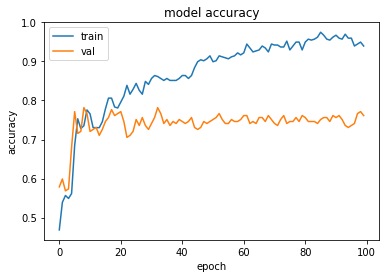

In [57]:
#plt.plot(range(1,EPOCHS+1),history.history['loss'], label='validation loss')

#plt.plot(range(1,EPOCHS+1),history.history['accuracy'], label='validation accuracy')
#plt.legend()
#plt.show(
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

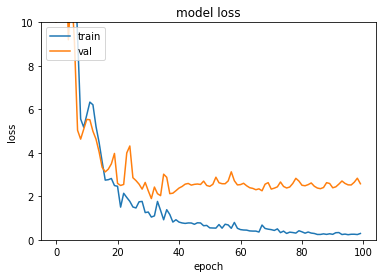

In [42]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim((0, 10))
plt.show()

In [21]:
history.model.evaluate([x_test, c_test] ,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.0117 - accuracy: 0.7563


[1.0117336511611938, 0.7563451528549194]

(197, 4)

[[  0   0   1   0]
 [  0   3  11   5]
 [  0   2 107   7]
 [  2   3  17  39]]


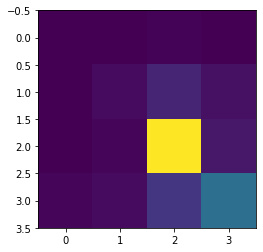

In [22]:
from sklearn.metrics import confusion_matrix
y_pred_abs = np.argmax(y_pred, axis=1)
y_test_abs = np.argmax(y_test, axis=1)
cm=confusion_matrix(y_test_abs,y_pred_abs)
plt.imshow(cm)
print(cm)

In [122]:
# 10-fold cross validation
if __name__ == "__main__":
    n_folds = 10
    data, labels, header_info = load_data()
    skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

    for i, (train, test) in enumerate(skf):
            print("Running Fold", i+1, "/", n_folds)
            model = None # Clearing the NN.
            model = create_model()
            train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-122-d878b0396607>, line 11)